In [1]:
%load_ext tikzmagic

---
slug: "/blog/softmaxregression"
date: "2021-03-15"
title: "Multinomial Logistic Regression (Softmax Regression)"
category: "Machine Learning"
order: 3
---

### Introduction

Softmax regression is a parametric classification method that is used to estimate multiclass output given real-valued input vectors.
In this post, cross entropy loss is used as the loss function and gradient descent (or batched gradient descent) is used to learn parameters.

The computation graph below shows how softmax regression works. The dot product of each input $\vec{x}$, and each vector $\vec{w}$ for each of $K$ classes is taken, resulting in values $z_1$ to $z_k$.
The softmax function is applied to then new vector $\vec{z}$, composed of $[z_1, z_2, ..., z_K]$.
The loss is then calculated using the cross entropy loss on label vector $\vec{y}$ and $\vec{z}$.

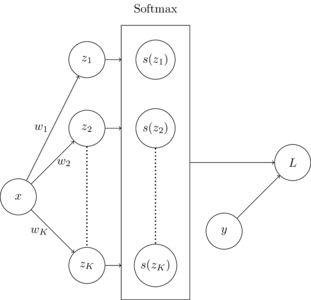

In [53]:
%%tikz -s 400,300 -sc=2
\node[draw, circle, minimum width=3em] (x) at (0, 0) {$x$};
\node[draw, circle, minimum width=3em] (z1) at (1, 2) {$z_1$};
\node[draw, circle, minimum width=3em] (z2) at (1, 1) {$z_2$};
\node[draw, circle, minimum width=3em] (zk) at (1, -1) {$z_K$};
\node[draw, circle, minimum width=3em] (sz1) at (2, 2) {$s(z_1)$};
\node[draw, circle, minimum width=3em] (sz2) at (2, 1) {$s(z_2)$};
\node[draw, circle, minimum width=3em] (szk) at (2, -1) {$s(z_K)$};
\node[draw, circle, minimum width=3em] (y) at (3, -.5) {$y$};
\node[draw, circle, minimum width=3em] (l) at (4, .5) {$L$};
\node[] (sm) at (2, 2.75) {Softmax};
\draw (1.5, 2.5) rectangle (2.5, -1.5);
\draw[->] (x) edge node[above, left] {$w_1$} (z1);
\draw[->] (x) edge node[below, right] {$w_2$} (z2);
\draw[->] (x) edge node[below, left] {$w_K$} (zk);
\draw[->] (z1) to (1.5, 2);
\draw[->] (z2) to (1.5, 1);
\draw[->] (zk) to (1.5, -1);
\draw[->] (2.5, .5) to (l);
\draw[->] (y) to (l);
\draw[dotted, line width=1pt] (z2) to (zk);
\draw[dotted, line width=1pt] (sz2) to (szk);

### Learning

Given a data set X of size $N$ with $D$ dimensions, parameters $w$ must be learned for each of $K$ classes that minimize our loss function $L_{\text{CE}}(y, \hat{y})$.
The weight vectors are learned using gradient descent.
The derivation for term $\frac{\partial L}{\partial w_i}$ in the weight update is displayed in the derivations section of this post.

$$
\begin{aligned}
    s(z_i) &= \frac{e^{z_i}}{\sum^{K}_{i=1}e^{z_i}} & \text{[Softmax function]}\\
    L_{\text{CE}}(y, \hat{y}) &= -\left[y\log\hat{y}\right]& \text{[Cross entropy loss]}\\
    w_i &= w_i - \alpha \frac{\partial L}{\partial w} & \text{[Weight update]}\\
    &= w_i - \alpha \left[x_i (s(z_i) - y_i) \right] &\\
    w_i &= w_i - \alpha \frac{1}{B}\sum^B_{j=1} \left[x_{j,i} (s(z_{j,i}) - y_{j,i}) \right] & \text{[Batch weight update]}\\
\end{aligned}
$$

### Code

Code for a softmax regression classifier is shown in the block below

In [2]:
from typing import List
from tqdm import trange
import torch

def Softmax(x: torch.Tensor) -> torch.Tensor:
    """ Apply softmax function to tensor

    Args:
        x: input tensor

    Returns:
        tensor with softmax function applied to all members
    """

    return torch.exp(x) / torch.sum(torch.exp(x), dim=1)[:, None]


def OneHotErrorRate(y: torch.Tensor, yhat: torch.Tensor) -> torch.Tensor:
    """ Calculate error rate for one-hot encoded multiclass problem

    Args:
        y: true labels
        yhat: predicted labels

    Returns:
        error rate
    """

    return ErrorRate(torch.argmax(y, dim=1), torch.argmax(yhat, dim=1))

class SoftmaxRegressionClassifier:


    def __init__(self) -> None:
        """ Instantiate softmax regression classifier
        """

        self.w = None
        self.calcError = OneHotErrorRate


    def fit(self, x, y, alpha=1e-4, epochs=1000, batch=32):
        """ Fit logistic regression classifier to dataset

        Args:
            x: input data
            y: input labels
            alpha: alpha parameter for weight update
            epochs: number of epochs to train
            batch: size of batches for training
        """

        y = torch.Tensor(createOneHotColumn(y.numpy())[0])
        self.w = torch.rand((y.shape[1], x.shape[1]))

        epochs = trange(epochs, desc='Accuracy')
        for epoch in epochs:

            rargs = torch.randperm(x.shape[0])
            x, y = x[rargs], y[rargs]

            start, end = 0, batch
            for b in range((x.shape[0]//batch)+1):
                if start < x.shape[0]:
                    sz = self.probs(x[start:end]) 
                    dw = self.calcGradient(x[start:end], y[start:end], sz)
                    self.w = self.w - alpha * dw

                start += batch
                end += batch

            sz = self.probs(x)
            accuracy = 1 - self.calcError(y, sz)
            epochs.set_description('Accuracy: %.4f' % accuracy)


    def probs(self, x: torch.Tensor) -> torch.Tensor:
        """ Predict probabilities of belonging to each class

        Args:
            x: input data

        Returns:
            probabilities for each member of input
        """

        return Softmax(torch.einsum('ij,kj->ik', x, self.w))


    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """ Predict labels

        Args:
            x: input data

        Returns:
            labels for each member of input
        """

        hx = self.probs(x)
        return torch.argmax(hx, dim=1)[:, None]


    def calcGradient(self, x: torch.Tensor, y: torch.Tensor, probs: torch.Tensor) -> torch.Tensor:
        """ Calculate weight gradient

        Args:
            x: input data
            y: input labels
            probs: predicted probabilities

        Returns:
            tensor of gradient values the same size as weights
        """

        return torch.einsum('ij,ik->jk', probs - y , x) / x.shape[0]



### Derivations

Derivative of arbitrary sigmoid output $s(z_j)$ with respect to arbitrary linear combination output $z_i$:

$$
\begin{aligned}
    \frac{\partial s(z_j) }{\partial z_i} &= \frac{\partial}{\partial z_i} \frac{e^{z_j}}{\sum^{K}_{k=1}e^{z_k}}\\\\
    &= \frac{\frac{\partial}{\partial z_i} e^{z_j} (\sum^{K}_{k=1}e^{z_k}) - e^{z_j} (\frac{\partial}{\partial z_i} \sum^{K}_{k=1}e^{z_k})}{(\sum^{K}_{k=1}e^{z_k})^2}\\\\
    &= 
    \begin{cases}
        \frac{\frac{\partial}{\partial z_i} e^{z_j} (\sum^{K}_{k=1}e^{z_k}) - e^{z_j} (\frac{\partial}{\partial z_i} \sum^{K}_{k=1}e^{z_k})}{(\sum^{K}_{k=1}e^{z_k})^2} & i = j\\\\
        \frac{\frac{\partial}{\partial z_i} e^{z_j} (\sum^{K}_{k=1}e^{z_k}) - e^{z_j} (\frac{\partial}{\partial z_i} \sum^{K}_{k=1}e^{z_k})}{(\sum^{K}_{k=1}e^{z_k})^2} & i \neq j\\
    \end{cases}\\\\
    &=
    \begin{cases}
        \frac{e^{z_i} (\sum^{K}_{k=1}e^{z_k}) - (e^{z_i})^2 }{(\sum^{K}_{k=1}e^{z_k})^2} & i = j\\\\
        \frac{0 - e^{z_j}e^{z_i} }{(\sum^{K}_{k=1}e^{z_k})^2} & i \neq j\\
    \end{cases}\\\\
    &=
    \begin{cases}
        s(z_i)(1 - s(z_i)) & i = j\\
        -s(z_j)s(z_i) & i \neq j\\
    \end{cases}\\\\
    &= s(z_i)(\delta_{i,j} - s(z_j)) \\
\end{aligned}
$$

Derivative of loss function $L$ with respect to arbitrary linear combination output $z_i$:

$$
\begin{aligned}
    \frac{\partial L}{\partial z_i} &= - \sum^{K}_{k=1} y_k \log s(z_k) \\
    &= - \left[ \frac{y_i}{s(z_i)}s(z_i)(1 - s(z_i)) - \sum^{K}_{k\neq i} \frac{y_k}{s(z_k)}(s(z_k)s(z_i))  \right]\\\\
    &= - \left[ y_i(1 - s(z_i)) - \sum^{K}_{k\neq i} y_k s(z_i) \right]\\\\
    &= - \left[ y_i - s(z_i) y_i  - \sum^{K}_{k\neq i} s(z_i) y_k  \right]\\\\
    &= - \left[ y_i - \sum^{K}_{k=1}  s(z_i) y_k \right]\\\\
    &= - \left[ y_i - s(z_i) \sum^{K}_{k=1}  y_k \right]\\\\
    &= s(z_i) - y_i\\\\
\end{aligned}
$$

Derivative of weight $w_i$ with respect to linear combination $z_i$:

$$
\begin{aligned}
    \frac{\partial z_i}{\partial w_i} &= \frac{\partial}{\partial w_i} w_i \times x_i\\
    &= x_i
\end{aligned}
$$

Derivative of weight $w_i$ with respect to loss:

$$
\begin{aligned}
    \frac{\partial L}{\partial w_i} &= \frac{\partial z_i}{\partial w_i}\frac{\partial L}{\partial z_i}\\
    &= x_i (s(z_i) - y_i)\\
\end{aligned}
$$